In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [2]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
from parameters import *
from lib.utils import *
from lib.attacks import *

import numpy as np
import tensorflow as tf

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


In [4]:
from keras.datasets import mnist

x_train, y_train, x_test, y_test = load_dataset_mnist()

y_train_cat = keras.utils.to_categorical(y_train, NUM_LABELS)
y_test_cat = keras.utils.to_categorical(y_test, NUM_LABELS)

---

In [8]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [36]:
def fn_mnist_A_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 100. - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [30]:
def fn_mnist_B_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=128,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=256,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 256])
    dense = tf.layers.dense(inputs=drop1_flat, units=512, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 10000. - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [52]:
def fn_mnist_C_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 784])

    dense = tf.layers.dense(inputs=input_layer, units=300, activation=tf.nn.relu)
    drop = tf.layers.dropout(
        inputs=dense, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    for _ in range(3):
        dense = tf.layers.dense(inputs=drop, units=300, activation=tf.nn.relu)
        drop = tf.layers.dropout(
            inputs=dense, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits Layer
    logits = tf.layers.dense(inputs=drop, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 1e2 - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [105]:
def fn_mnist_D_hinge(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 784])

    dense = tf.layers.dense(inputs=input_layer, units=1200, activation=tf.nn.relu)
    drop = tf.layers.dropout(
        inputs=dense, rate=0., training=(mode == tf.estimator.ModeKeys.TRAIN))
    for _ in range(5):
        dense = tf.layers.dense(inputs=drop, units=1200, activation=tf.nn.relu)
        drop = tf.layers.dropout(
            inputs=dense, rate=0., training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits Layer
    logits = tf.layers.dense(inputs=drop, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., 1e4 - y_label + y_max))
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
def fn_mnist_A_margin(features, labels, mode):
    """Model function for CNN."""
    
    C = 1e2
    lamda = 1e-2
    EPS = 1e-6
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=64,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0., training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 64])
    dense = tf.layers.dense(inputs=drop1_flat, units=128, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0., training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., C - y_label + y_max))
    
    # Add penalty term
    grad = tf.gradients(y_label, input_layer, name='grad')
    grad_reshape = tf.reshape(grad, shape=[-1, 28 * 28])
    # grad_norm = tf.reduce_sum(tf.square(grad_reshape), axis=1)
    grad_norm = tf.sqrt(tf.reduce_sum(tf.square(grad_reshape), axis=1))
    # diff = tf.square(y_label - y_max)
    diff = tf.abs(y_label - y_max)
    # diff = y_label
    margin = tf.divide(grad_norm, diff + EPS)
    penalty = tf.reduce_sum(margin, name='penalty')
    loss += lamda * penalty
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [241]:
def fn_mnist_B_margin(features, labels, mode):
    """Model function for CNN."""
    
    C = 1
    lamda = 1e-7
    EPS = 1e-6
    
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=128,
        kernel_size=[3, 3],
        activation=tf.nn.relu)

    # Convolutional Layer and pooling #2
    conv2 = tf.layers.conv2d(
        inputs=conv1,
        filters=256,
        kernel_size=[3, 3],
        activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dropout #1
    drop1 = tf.layers.dropout(
        inputs=pool1, rate=0.25, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Dense Layer
    drop1_flat = tf.reshape(drop1, [-1, 12 * 12 * 256])
    dense = tf.layers.dense(inputs=drop1_flat, units=512, activation=tf.nn.relu)
    drop2 = tf.layers.dropout(
        inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits Layer
    logits = tf.layers.dense(inputs=drop2, units=10, name="logits")

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
 
    # Structured hinge loss max{0, 1 - (y_label - y_max)}
    # Not so elegant way to index tensor with another tensor
    indices = tf.range(tf.shape(logits)[0])
    gather_ind = tf.stack([indices, labels], axis=1)
    y_label = tf.gather_nd(logits, gather_ind)
    # Get 2 largest outputs
    y_2max = tf.nn.top_k(logits, 2)[0]
    # Find y_max = max(z[i != y])
    i_max = tf.to_int32(tf.argmax(logits, axis=1))
    y_max = tf.where(tf.equal(labels, i_max), y_2max[:, 1],
                     y_2max[:, 0])
    loss = tf.reduce_sum(tf.maximum(0., C - y_label + y_max))
    
    # Add penalty term
    grad = tf.gradients(y_label, input_layer, name='grad')
    grad_reshape = tf.reshape(grad, shape=[-1, 28 * 28])
    grad_norm = tf.reduce_sum(tf.square(grad_reshape), axis=1)
    diff = tf.square(y_label - y_max)
    margin = tf.divide(grad_norm, diff)
    # margin = tf.divide(grad_norm, (y_label + EPS))
    penalty = tf.reduce_sum(margin, name='penalty')
    loss += lamda * penalty
    
    # Calculate batch accuracy
    tmp = tf.cast(tf.equal(i_max, labels), dtype=tf.float32)
    accuracy = tf.reduce_mean(tmp, name="accuracy")
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [6]:
path = './tmp/mnist_0_margin_c1e2_l1e-2/'
model_fn = fn_mnist_A_margin
# path = './tmp/mnist_a_margin_c1e4/'
# model_fn = fn_mnist_A_hinge
model = build_cnn_mnist()
# model = build_cnn_mnist_2()
# model = build_dnn_mnist(784, 300, 4)
# model = build_dnn_mnist(784, 1200, 6)

In [7]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=model_fn, model_dir=path)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './tmp/mnist_0_margin_c1e2_l1e-2/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa67585be48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [8]:
#tensors_to_log = {"probabilities": "softmax_tensor"}
#tensors_to_log = {"gather_ind": "gather_ind", "y_l": "y_l"}
tensors_to_log = {"accuracy": "accuracy", "penalty": "penalty"}
#tensors_to_log = {"accuracy": "accuracy"}
#tensors_to_log = {}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=100)

In [9]:
def get_weights(estimator):
    """
    Extract weights from TF Estimator. Only works with a simple CNN/DNN.
    """

    weights = []
    weight = []
    layer_names = estimator.get_variable_names()
    for layer_name in layer_names:
        if layer_name.endswith("kernel"):
            weight.insert(0, estimator.get_variable_value(layer_name))
            weights.append(weight)
            weight = []
        elif layer_name.endswith("bias"):
            weight.append(estimator.get_variable_value(layer_name))
            
    return weights


def load_weights(model, weights):
    """
    Set weights in Keras model with a list of weights.
    """
    
    i = 0
    for layer in model.layers:
        # Check if layer has trainable weights
        if not layer.trainable_weights:
            continue
        # Set weight
        layer.set_weights(weights[i])
        i += 1
        
    assert i == len(weights), "Number of layers mismatch."

---

In [10]:
weight_path = path + 'model'
n_epochs = 200
stop_counter = 0

min_test_loss = np.inf
save_i = 0
train_out = {'accuracy': [], 'loss':[]}
test_out = {'accuracy': [], 'loss':[]}

for i in range(n_epochs):
    
    if i % 2 is 0:
        try:
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                batch_size=128,
                num_epochs=2,
                shuffle=True)       

            mnist_classifier.train(
                input_fn=train_input_fn,
                hooks=[logging_hook])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_train},
                y=y_train,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            train_out['accuracy'].append(eval_results['accuracy'])
            train_out['loss'].append(eval_results['loss'])

            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": x_test},
                y=y_test,
                num_epochs=1,
                shuffle=False)
            eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
            test_loss = eval_results['loss']
            test_out['accuracy'].append(test_loss)
            test_out['loss'].append(eval_results['loss'])

            if test_loss < min_test_loss:
                min_test_loss = test_loss
                save_i = i
                weights = get_weights(mnist_classifier)
                load_weights(model, weights)
                model.save_weights(weight_path + '.h5')
                stop_counter = 0
                print('=========== (-) Test loss: {:.5f} ============='.format(test_loss))
            else:
                stop_counter += 1
                print('=========== (+) Test loss: {:.5f} ============='.format(test_loss))

            if stop_counter == 5:
                break
                
        except:
            raise
            print('--------- NaN encountered - epoch {} ---------'.format(i))
            pass

print('================ Finished in {} epochs ================'.format(i))
pickle.dump(train_out, open(weight_path + '_train.p', 'wb'))
pickle.dump(test_out, open(weight_path + '_test.p', 'wb'))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./tmp/mnist_0_margin_c1e2_l1e-2/model.ckpt.
INFO:tensorflow:accuracy = 0.0703125, penalty = 317.42233
INFO:tensorflow:loss = 12814.0625, step = 0
INFO:tensorflow:global_step/sec: 88.3602
INFO:tensorflow:accuracy = 0.0625, penalty = 29.615326 (1.139 sec)
INFO:tensorflow:loss = 12974.3125, step = 100 (1.138 sec)
INFO:tensorflow:global_step/sec: 104.228
INFO:tensorflow:accuracy = 0.140625, penalty = 24.690353 (0.955 sec)
INFO:tensorflow:loss = 13024.487, step = 200 (0.954 sec)
INFO:tensorflow:global_step/sec: 107.125
INFO:tensorflow:accuracy = 0.2109375, penalty = 119.797195 (0.934 sec)
INFO:tensorflow:loss = 12874.214, step = 300 (0.934 sec)
INFO:tensorflow:global_step/sec: 106.044
INFO:tensorflow:accuracy = 0

KeyboardInterrupt: 

In [75]:
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": x_train},
#     y=y_train,
#     batch_size=128,
#     num_epochs=5,
#     shuffle=True)

# mnist_classifier.train(
#     input_fn=train_input_fn,
#     hooks=[logging_hook])

In [76]:
model = build_cnn_mnist()
#model = build_cnn_mnist_2()
#model = build_dnn_mnist(784, 300, 4)
#model = build_dnn_mnist(784, 1200, 6)

In [77]:
model.load_weights(path + 'model.h5')

In [78]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 83us/step


[1.0007422032472302, 0.9887]

In [79]:
model.evaluate(x_train, y_train_cat)

60000/60000 [==============================] - 4s 69us/step


[0.302701156801376, 0.9965666666666667]

In [80]:
# Can we change margin? it doesn't have to be 1

---

In [61]:
model = build_cnn_mnist()
#model.load_weights('./tmp/weights/mnist_cnn_hinge.h5')
#model.load_weights('./tmp/weights/mnist_cnn_smxe.h5')
model.load_weights('./tmp/mnist_cnn_margin_C1_L1/model.h5')

weight_path = './tmp/mnist_cnn_margin_C1_L1/model'

In [47]:
from lib.OptCarlini import *

In [68]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.4,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         weight_path + '.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=7.587, loss=1.774, obj=9.361
Step: 50, norm=6.586, loss=0.387, obj=6.973
Step: 100, norm=5.647, loss=0.028, obj=5.675
Step: 150, norm=4.993, loss=0.012, obj=5.005
Step: 200, norm=4.715, loss=0.000, obj=4.715
Step: 250, norm=4.574, loss=0.027, obj=4.601
Step: 300, norm=4.496, loss=0.000, obj=4.496
Step: 350, norm=4.448, loss=0.000, obj=4.448
Step: 400, norm=4.403, loss=0.019, obj=4.423
Step: 450, norm=4.396, loss=0.000, obj=4.396
Step: 500, norm=4.375, loss=0.012, obj=4.387
Step: 550, norm=4.369, loss=0.002, obj=4.371
Step: 600, norm=4.359, loss=0.004, obj=4.362
Step: 650, norm=4.351, loss=0.001, obj=4.352
Step: 700, norm=4.346, loss=0.000, obj=4.346
Step: 750, norm=4.337, loss=0.002, obj=4.340
Step: 800, norm=4.341, loss=0.000, obj=4.341
Step: 850, norm=4.329, loss=0.003, obj=4.332
Step: 900, norm=4.323, loss=0.010, obj=4.333
Step: 950, norm=4.328, loss=0.000, obj=4.328
Step: 0, norm=7.823, loss=1.231, obj=9.054
Step: 50, norm=6.108, loss=0.000, obj=6.108
Step: 100, norm=

KeyboardInterrupt: 

In [14]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.470, loss=0.000, obj=13.470
Step: 50, norm=8.580, loss=0.000, obj=8.580
Step: 100, norm=5.743, loss=0.013, obj=5.756
Step: 150, norm=4.380, loss=0.000, obj=4.380
Step: 200, norm=3.581, loss=0.000, obj=3.581
Step: 250, norm=3.116, loss=0.000, obj=3.116
Step: 300, norm=2.789, loss=0.000, obj=2.789
Step: 350, norm=2.601, loss=0.000, obj=2.601
Step: 400, norm=2.458, loss=0.000, obj=2.458
Step: 450, norm=2.356, loss=0.000, obj=2.356
Step: 500, norm=2.277, loss=0.000, obj=2.277
Step: 550, norm=2.215, loss=0.000, obj=2.215
Step: 600, norm=2.167, loss=0.000, obj=2.167
Step: 650, norm=2.123, loss=0.000, obj=2.123
Step: 700, norm=2.082, loss=0.000, obj=2.082
Step: 750, norm=2.070, loss=0.000, obj=2.070
Step: 800, norm=2.048, loss=0.000, obj=2.048
Step: 850, norm=2.022, loss=0.000, obj=2.022
Step: 900, norm=1.998, loss=0.000, obj=1.998
Step: 950, norm=1.991, loss=0.000, obj=1.991
Step: 0, norm=13.357, loss=0.000, obj=13.357
Step: 50, norm=8.494, loss=0.000, obj=8.494
Step: 100, n

KeyboardInterrupt: 

In [18]:
opt = OptCarlini(model, target=False, c=1, lr=0.01, init_scl=0.1,
                 use_bound=False, loss_op=0, k=0, var_change=True,
                 use_mask=False)

x_adv = np.zeros_like(x_test)
norm = np.zeros(len(x_test))

for i, (x, y) in enumerate(zip(x_test, y_test_cat)):
    y_pred = predict(model, x)
    if y_pred is not np.argmax(y):
        x_adv[i], norm[i] = opt.optimize(x, y, 
                                         './tmp/mnist_cnn_smxe.h5', 
                                         n_step=1000, prog=True)

Step: 0, norm=13.448, loss=0.000, obj=13.448
Step: 50, norm=8.389, loss=0.000, obj=8.389
Step: 100, norm=5.837, loss=0.000, obj=5.837
Step: 150, norm=4.483, loss=0.003, obj=4.486
Step: 200, norm=3.761, loss=0.000, obj=3.761
Step: 250, norm=3.256, loss=0.000, obj=3.256
Step: 300, norm=2.922, loss=0.000, obj=2.922
Step: 350, norm=2.702, loss=0.000, obj=2.702
Step: 400, norm=2.547, loss=0.000, obj=2.547
Step: 450, norm=2.442, loss=0.000, obj=2.442
Step: 500, norm=2.349, loss=0.000, obj=2.349
Step: 550, norm=2.266, loss=0.027, obj=2.292
Step: 600, norm=2.220, loss=0.000, obj=2.220
Step: 650, norm=2.178, loss=0.000, obj=2.178
Step: 700, norm=2.142, loss=0.000, obj=2.142
Step: 750, norm=2.109, loss=0.000, obj=2.109
Step: 800, norm=2.085, loss=0.000, obj=2.085
Step: 850, norm=2.074, loss=0.000, obj=2.074
Step: 900, norm=2.058, loss=0.000, obj=2.058
Step: 950, norm=2.039, loss=0.000, obj=2.039
Step: 0, norm=13.334, loss=0.014, obj=13.348
Step: 50, norm=8.460, loss=0.000, obj=8.460
Step: 100, n

KeyboardInterrupt: 

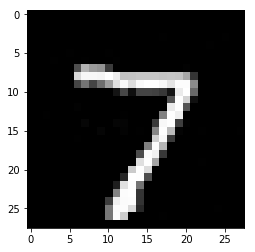

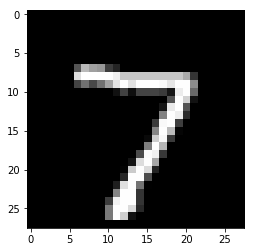

7

In [12]:
i = 0
plt.imshow(x_adv[i].reshape(28, 28), cmap='gray')
plt.show()
plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
plt.show()
predict(model, x_adv[i])

In [41]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.7619686784297228


In [11]:
adv_path = './tmp/adv/mnist_cnn_hinge_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.99
1.7483367365896703


In [39]:
adv_path = './tmp/adv/mnist_cnn_hinge_10_ut'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
1.9846761872768401


In [9]:
adv_path = './tmp/adv/mnist_cnn_smxe_ut_w'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

1.0
2.0220260658711195


In [13]:
adv_path = './tmp/adv/mnist_cnn_margin_C1_L1'

x_adv = pickle.load(open(adv_path + '.p', 'rb'))
norm = pickle.load(open(adv_path + '_norm.p', 'rb'))

print(eval_adv(model, x_adv, y_test_cat[:1000], target=False))
print(np.mean(norm))

0.257
0.6817249667933211


In [38]:
model.evaluate(x_test, y_test_cat)

10000/10000 [==============================] - 1s 132us/step


[0.46184693212509154, 0.96]

In [37]:
test_out

{'accuracy': [0.8874,
  0.9267,
  0.9428,
  0.8998,
  0.958,
  0.947,
  0.9274,
  0.9514,
  0.9574,
  0.96,
  0.9482,
  0.9489],
 'loss': [59.199047,
  38.387955,
  30.049332,
  45.49747,
  22.247637,
  25.692705,
  39.69093,
  23.924044,
  21.638086,
  19.400446,
  24.211601,
  23.441643]}